In [10]:
import torch
from transformers import  RobertaTokenizer, RobertaForSequenceClassification, AdamW
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, SequentialSampler

from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import torch.optim
import numpy as np
import pandas as pd
import time
import datetime
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from bs4 import BeautifulSoup
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from textwrap import wrap
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
from collections import Counter


import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras 
from keras import backend as K
from keras.layers import LSTM,Dense,Bidirectional,Input
from keras.models import Model


MAX_LEN = 38

# Select cpu or cuda
run_on = 'cpu'
device = torch.device(run_on)

df = pd.read_csv('/Users/nfanlo/Desktop/Python/DataAnalysis/Datasets TFG/TFG/Task1-train-dev/train_dev/train_dev_all.csv')
print(df.shape)
df.isnull().sum()
df.sentiment.replace("P" , 2 , inplace = True)
df.sentiment.replace("N" , 0 , inplace = True)
df.sentiment.replace("NEU" , 1, inplace = True)
df['review'] = df['text']
df.drop('text', axis=1, inplace=True)
df['label'] = df['sentiment']
df.drop('sentiment', axis=1, inplace=True)


print(df)

(7234, 2)
                                                 review  label
0     @dianalaa32 Es una escena de uno de los docume...      2
1     Qué feo es tener que terminar con alguien; y m...      0
2     Oído en McDonalds "el mejor mannequin challeng...      0
3     Tengo que aceptar que me esta hundiendo el con...      1
4     Mmm no quiero hacer spoiler pero hoy va a ver ...      1
...                                                 ...    ...
7229  @sebatramp Acá también, Seba ???? Para peor el...      0
7230  @Phoyu_Agustina no soy hack pero es imposible ...      1
7231  Nadie te vende un The Last of Us Remastered po...      0
7232  Me propuse dejar las redes, las salidas &amp; ...      1
7233  @irenichus siii! Voy como en media hora. Me va...      2

[7234 rows x 2 columns]


In [11]:
#Environment stopwords
stop = set(stopwords.words('spanish'))
punctuation = list(string.punctuation)
stop.update(punctuation)

#Data cleaning stopwords (ignored)
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['review']=df['review'].apply(denoise_text)

/Users/nfanlo/Library/Python/3.8/lib/python/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [12]:
review = df['review']
labels = df['label']

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(review, labels, stratify=labels, test_size=0.2)

# Report datasets lenghts
print('Training set length : {}'.format(len(X_train)))
print('Validation set length : {}'.format(len(X_val)))

Training set length : 5787
Validation set length : 1447


In [13]:
# Tokenization

tokenizer = RobertaTokenizer.from_pretrained("roberta-base",
            do_lower_case=True)

def preprocessing(dataset):
    input_ids = []
    attention_mask = []
    for doc in dataset:
        encoded_doc = tokenizer.encode_plus(doc,
                   add_special_tokens=True, max_length=MAX_LEN,
                   truncation=True ,pad_to_max_length=True,
                   return_token_type_ids = False,
                   return_attention_mask = True,)
        input_ids.append(encoded_doc['input_ids'])
        attention_mask.append(encoded_doc['attention_mask'])
    return (torch.tensor(input_ids),
           torch.tensor(attention_mask))

# Apply preprocessing to dataset
X_train_inputs, X_train_masks = preprocessing(X_train)
X_val_inputs, X_val_masks = preprocessing(X_val)

# Report max n° tokens in a sentence
max_len = max([torch.sum(sen) for sen in X_train_masks])
print('Max n°tokens in a sentence: {0}'.format(max_len))

/Users/nfanlo/Library/Python/3.8/lib/python/site-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Max n°tokens in a sentence: 38


In [14]:
#Data loaders
batch_size = 16

y_train_labels = torch.tensor(y_train.values)
y_val_labels = torch.tensor(y_val.values)

def dataloader(x_inputs, x_masks, y_labels):
    data = TensorDataset(x_inputs, x_masks, y_labels)
    sampler = SequentialSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size, num_workers=4)
    
    return dataloader

train_dataloader = dataloader(X_train_inputs, X_train_masks, y_train_labels)
val_dataloader = dataloader(X_val_inputs, X_val_masks, y_val_labels)

In [15]:
#Cargamos el modelo + optimizador + definimos EPOCHS + Scheduler
#Modelo
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=3,
 output_attentions=False, output_hidden_states=False)

optimizer = AdamW(model.parameters(), lr = 4e-5, eps = 1e-6)

epochs=5

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps= total_steps)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

In [16]:
print(model)

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerN

In [17]:
#Definimos una funcion para formatear el tiempo y otra para calcular la exactitud
#fuction to format time
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

#function to compute accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

-----------------Training--------------------

======= Epoch 1 / 5 =======
batch loss: 1.0910661220550537 | avg loss: 1.0910661220550537
batch loss: 1.0742703676223755 | avg loss: 1.0826682448387146
batch loss: 1.0694100856781006 | avg loss: 1.0782488584518433
batch loss: 1.1400320529937744 | avg loss: 1.093694657087326
batch loss: 1.1626758575439453 | avg loss: 1.10749089717865
batch loss: 1.1689671277999878 | avg loss: 1.1177369356155396
batch loss: 1.0198320150375366 | avg loss: 1.1037505183901106
batch loss: 1.1825615167617798 | avg loss: 1.1136018931865692
batch loss: 1.1611988544464111 | avg loss: 1.1188904444376628
batch loss: 1.1087017059326172 | avg loss: 1.1178715705871582
batch loss: 1.0447044372558594 | avg loss: 1.1112200130115857
batch loss: 1.1058145761489868 | avg loss: 1.1107695599397023
batch loss: 1.081311821937561 | avg loss: 1.1085035800933838
batch loss: 1.0940487384796143 | avg loss: 1.1074710914066859
batch loss: 1.092970609664917 | avg loss: 1.1065043926239013


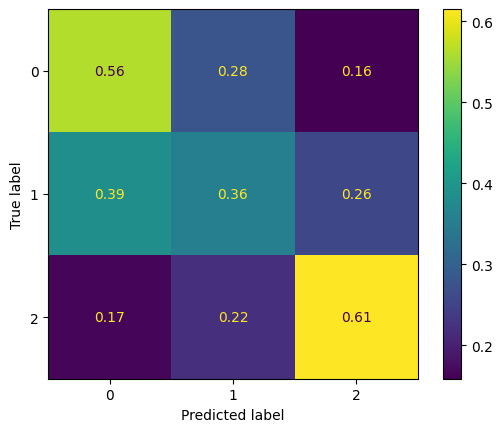

              precision    recall  f1-score   support

           1       0.56      0.56      0.56       566
           2       0.40      0.36      0.38       463
           3       0.55      0.61      0.58       418

    accuracy                           0.51      1447
   macro avg       0.50      0.51      0.51      1447
weighted avg       0.51      0.51      0.51      1447



In [18]:
#Definimos la funcion para entrenar el modelo y entregar los resultados en el set de validación
#Train model
def training(n_epochs, training_dataloader, validation_dataloader):
    for epoch_i in range(0, n_epochs):
        print('======= Epoch {:} / {:} ======='.format(epoch_i + 1, epochs))
        # Mira cuanto tiempo le cuesta entrenar un EPOCH.
        t0 = time.time()
        # Resetea la perdida para este EPOCH.
        total_loss = 0
        # Pone el modelo en modo entrenamiento.
        model.train()
        # Para cada batch en el training data
        for step, batch in enumerate(training_dataloader):
            batch_loss = 0
            # Unpack this training batch from dataloader
            #   [0]: input ids, [1]: attention masks, 
            #   [2]: labels
            b_input_ids,b_input_mask, b_labels = tuple(
                                t.to(device) for t in batch)

            # Limpia el gradiente calculado anteriormente
            model.zero_grad()

            # Genera un paso adelante
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels)

            # Saca el loss value fuera del output
            loss = outputs[0]
            batch_loss += loss.item()
            total_loss += loss.item()

            # Genera un paso atras
            loss.backward()

            # Clipea el los gradientes a 1.0.
            torch.nn.utils.clip_grad_norm_(model.parameters(),
                                            1.0)

            # Actualiza los parametros
            # ¿take a step using the computed gradient?
            optimizer.step()
            scheduler.step()

        # Calcula el average loss sobre el training data.
        avg_train_loss = total_loss / len(train_dataloader)


        #Validación
        # Despues de completar un entrenamiento genera un paso de validacion

        t0 = time.time()

        # Pone el modelo en modo evaluación
        model.eval()

        # Trackea las variables
        eval_loss, eval_accuracy = 0, 0
        all_logits = []
        all_labels = []
        # Evalua el data para un epoch mas
        for step, batch in enumerate(validation_dataloader):
            # Add batch to device
            # Unpack this training batch from our dataloader.
            #   [0]: input ids, [1]: attention masks,
            #   [2]: labels
            b_input_ids, b_input_mask, b_labels = tuple(
                                t.to(device) for t in batch)


            # El modelo no computa los gradientes
            with torch.no_grad():
                # Paso adelante 
                # Devolvemos los loggits 
                outputs = model(b_input_ids,
                                token_type_ids=None,
                                attention_mask=b_input_mask)

            # Los "logits" son el valor de salida
            # Prioriza aplicar la funcion de activación
            logits = outputs[0]

            # Mueve los logits y labels a la CPU
            logits = logits.detach().cpu().numpy()
            b_labels = b_labels.to('cpu').numpy()

            # Guarda los logits y labels del batch
            # Utilizamos esto en la matriz de confusión
            predict_labels = np.argmax(logits, axis=1).flatten()
            all_logits.extend(predict_labels.tolist())
            all_labels.extend(b_labels.tolist())

            # Calcula la precision para este batch
            tmp_eval_accuracy = flat_accuracy(logits, b_labels)
            # Accumula la precisión total
            eval_accuracy += tmp_eval_accuracy

    #Print la matriz de confussión"
    conf = confusion_matrix(all_labels, all_logits, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=conf)
    disp.plot()
    plt.show()

    target_names = ['1', '2', '3']
    print(classification_report(all_labels, all_logits, target_names=target_names))

#Llamamos a la funcion para entrenar el modelo
training(epochs, train_dataloader, val_dataloader)